This notebook provides some example cases for using EIF. Three cases of single blob, multiple blobs, and sinusoidal data that are presented in the paper are used here for this demo. In each case we compare the standard Isolation Forest with the Extended Isolation Forest using the eif package. The eif package can easily be installed using pip as follows:

pip install eif

Various plots such as scatter plots, score distributions, score maps, and tree and forest visualizations are presented. This notebook is meant to demonstrate how to use the basic functionality of eif. For the details of how the algorithm works, see the paper(s) referenced in the repository. 

# Imports

While the core package only needs numpy, we make use of other packages in creating our test functions below, mostly for visualization or data generation. They are not however, necessary for the algorithm to run. Feel free to use any other package you like. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import seaborn as sb
import eif as iso

sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed
import sys

sys.path.append("..")
import sif
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs, load_iris
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Utility Functions

These utility functions are used in creating the radial plots below. We use these two functions to find the depth (not anomaly score) a given data point reaches in an Isolation Forest tree. 

In [2]:
def getDepth(x, root, d):
    n = root.n
    p = root.p
    if root.ntype == "exNode":
        return d
    else:
        if (x - p).dot(n) < 0:
            return getDepth(x, root.left, d + 1)
        else:
            return getDepth(x, root.right, d + 1)


def getVals(forest, x, sorted=True):
    theta = np.linspace(0, 2 * np.pi, forest.ntrees)
    r = []
    for i in range(forest.ntrees):
        temp = forest.compute_paths_single_tree(np.array([x]), i)
        r.append(temp[0])
    if sorted:
        r = np.sort(np.array(r))
    return r, theta

# Construct Datasets

In [3]:
def construct_datasets(n_samples):
    X, y = make_classification(
        n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
    )
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)
    
    guassian_one = rng.normal(5, 1, (n_samples, 10))
    guassian_two = rng.normal(-5, 1, (n_samples, 10))
    X = np.concatenate((guassian_one, guassian_two))
    y = np.concatenate(([0] * n_samples, [1] * n_samples))
    ind_high_dim_guassian = (X, y)
    
    
    centers = [(-5, -5), (5, 5)]
    X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)
    y[: n_samples // 2] = 0
    y[n_samples // 2 :] = 1
    separated_blobs = (X, y)
    
    
    centers = [(1, 1), (3, 3)]
    X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)
    y[: n_samples // 2] = 0
    y[n_samples // 2 :] = 1
    overlapping_blobs = (X, y)
    
    iris = load_iris()
    X, y = iris.data[:, :2], iris.target  # we only take the first two features.
    iris_first_two_feats = (X, y)
    
    return [
        make_moons(n_samples=n_samples, noise=0.3, random_state=0),
        make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
        linearly_separable,
        separated_blobs,
        overlapping_blobs,
        iris_first_two_feats
    ]

datasets = construct_datasets(500)
names = ['moons', 'circles', 'linearly_separable', 'separated_blobs', 'overlapping_blobs', 'iris_first_two_feats']

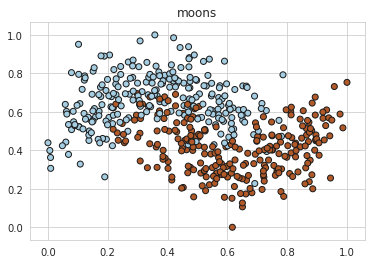

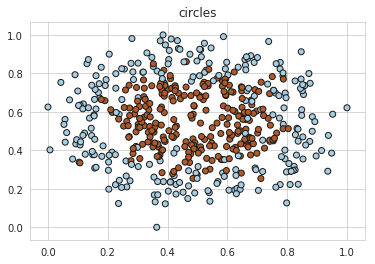

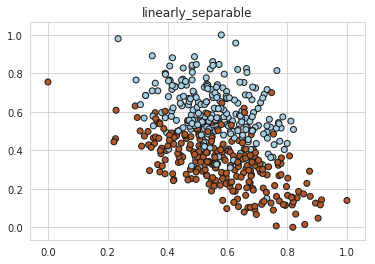

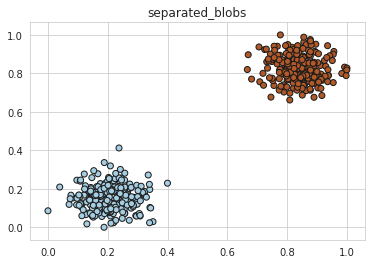

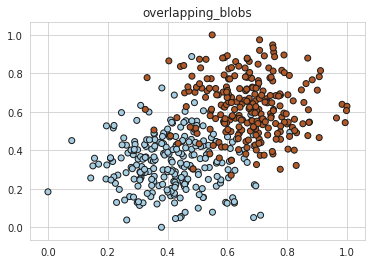

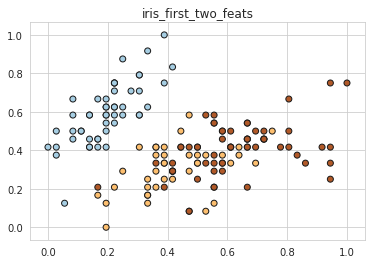

In [4]:
for name, ds in zip(names, datasets):
    X, y = ds
    # Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
    X = MinMaxScaler().fit_transform(X)

    plt.title(name)
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")
    plt.show();

In [5]:
def plot_sif(ds, name, n_trees=500):
    X, y = ds
    X = MinMaxScaler().fit_transform(X)

    x1, x2 = X[:, 0], X[:, 1]
    xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 30), np.linspace(-0.5, 1.5, 30))

    F0 = iso.iForest(X, ntrees=n_trees, sample_size=int(0.5 * len(X)), ExtensionLevel=0)
    S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
    S0 = S0.reshape(xx.shape)

    F1 = sif.iForest(X, y, ntrees=n_trees, sample_size=int(0.5 * len(X)), ExtensionLevel=0)
    F1.fit(X, y)
    S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
    S1 = S1.reshape(xx.shape)

    f = plt.figure(figsize=(15, 10))

    ########################
    ### SCORE MAPS
    #########################
    ax1 = f.add_subplot(2, 3, 2)
    levels = np.linspace(np.min(S0), np.max(S0), 10)
    CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
    plt.scatter(x1, x2, s=15, c=y, edgecolor="k")
    plt.axis("equal")
    plt.title("standard IF\nscore map")
    
    
    ax2 = f.add_subplot(2, 3, 5)
    levels = np.linspace(np.min(S1), np.max(S0), 10)
    CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
    plt.scatter(x1, x2, s=15, c=y, edgecolor="k")
    plt.axis("equal")
    plt.title(f"supervised IF\nscore map")

    ########################
    ### ANOMALY SCORE DIST
    #########################
    S0 = F0.compute_paths(X_in=X)
    S1 = F1.compute_paths(X_in=X)

    ax3 = f.add_subplot(2, 3, 1)
    sb.distplot(S0, kde=True, color="b")
    plt.title("standard IF\ndist of anomaly scores")

    ax4 = f.add_subplot(2, 3, 4, sharex=ax3)
    sb.distplot(S1, kde=True, color="b")
    plt.title(f"supervised IF\ndist of anomaly scores")

    ########################
    ### TREE VISUALIZATION
    #########################
    Sorted = True
    
    inlier, outlier = np.array([0.5, 0.5]), np.array([15.0, 15.0])
    if name == 'separated_blobs':
        inlier = np.array([0.25, 0.25])

    
    ax5 = f.add_subplot(233)
    rn, thetan = getVals(F0, np.array(inlier), sorted=Sorted)
    ax5.hist(rn, color="b", alpha=0.3, label='inlier')
    ra, thetaa = getVals(F0, np.array(outlier), sorted=Sorted)
    ax5.hist(ra, color="r", alpha=0.3, label='outlier')
    ax5.set_title(
        "standard IF, depth of single point in tree\nNominal: Mean={0:.2f}, Var={1:.2f}. Anomaly: Mean={2:.2f}, Var={3:.2f}".format(
            np.mean(rn), np.var(rn), np.mean(ra), np.var(ra)
        )
    )
    ax5.legend()


    ax6 = f.add_subplot(236, sharex=ax5)
    rn, thetan = getVals(F1, np.array(inlier), sorted=Sorted)
    ax6.hist(rn, color="b", alpha=0.3, label='inlier')
    ra, thetaa = getVals(F1, np.array(outlier), sorted=Sorted)
    ax6.hist(ra, color="r", alpha=0.3, label='outlier')
    ax6.set_title(
        "supervised IF, depth of single point in tree\nNominal: Mean={0:.2f}, Var={1:.2f}. Anomaly: Mean={2:.2f}, Var={3:.2f}".format(
            np.mean(rn), np.var(rn), np.mean(ra), np.var(ra)
        )
    )
    ax6.legend()
    f.suptitle(name)

    plt.show()

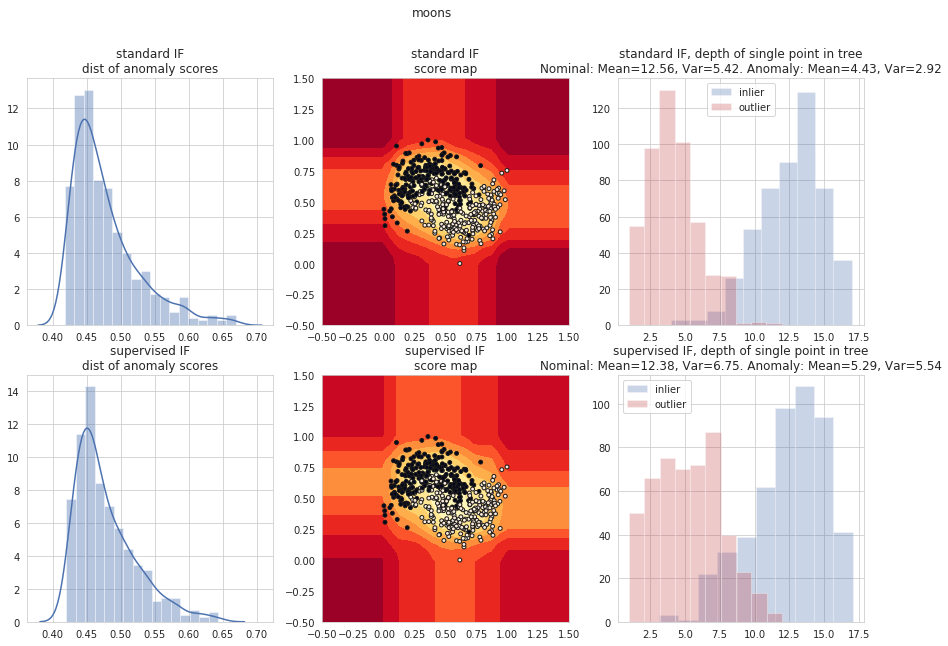

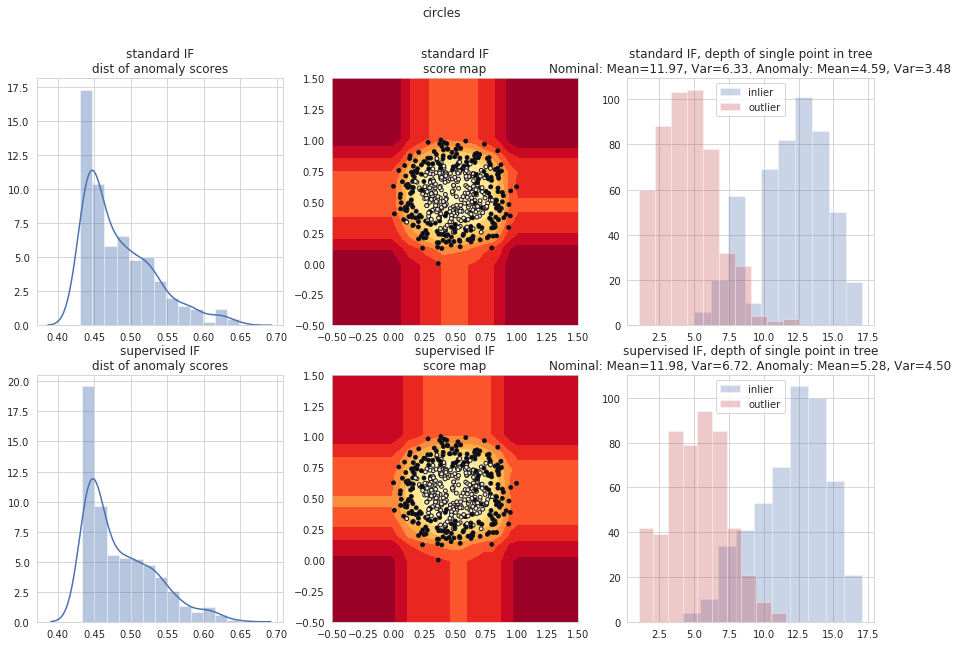

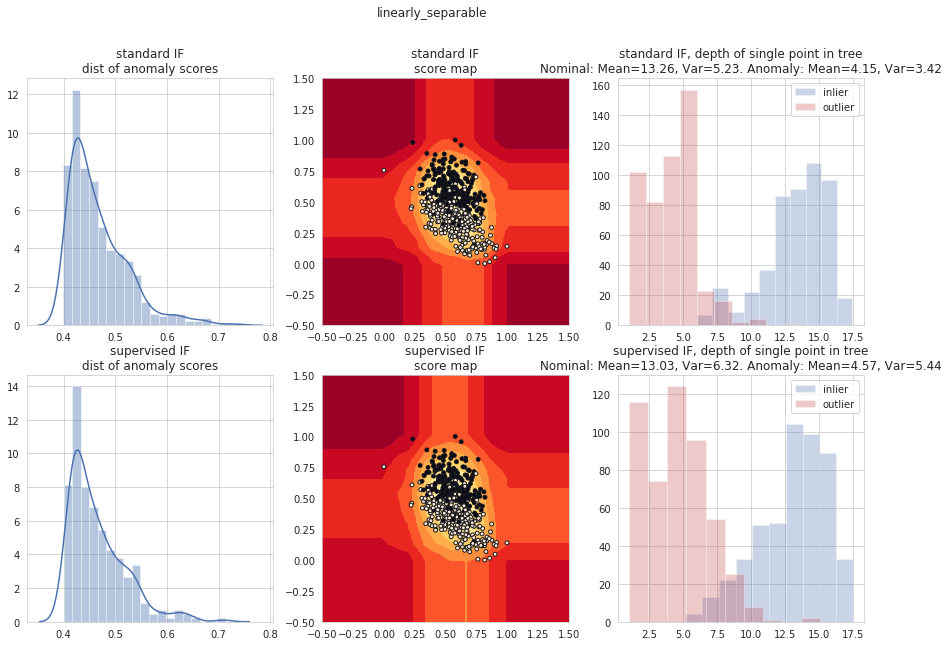

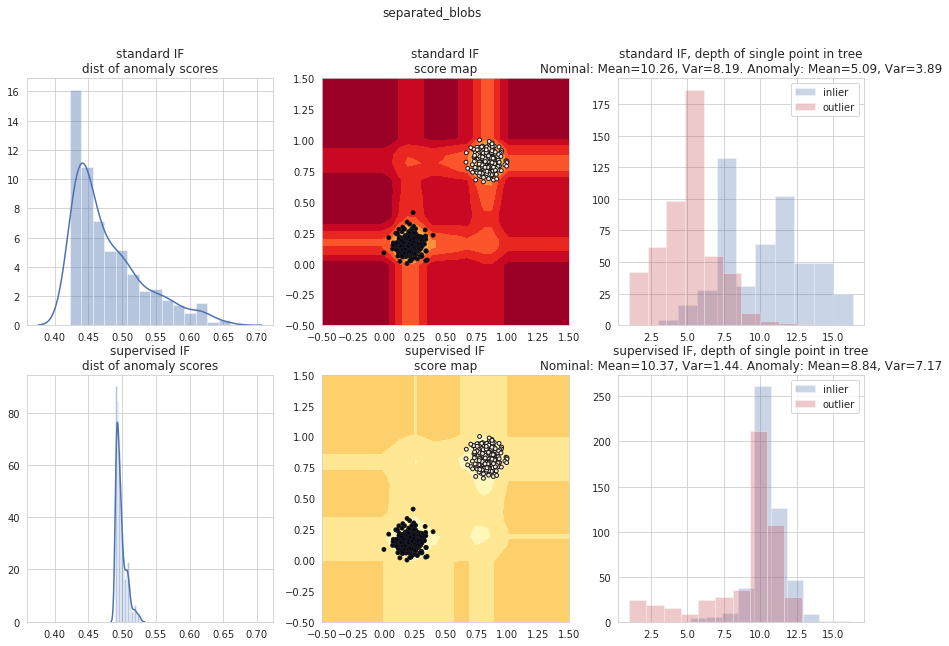

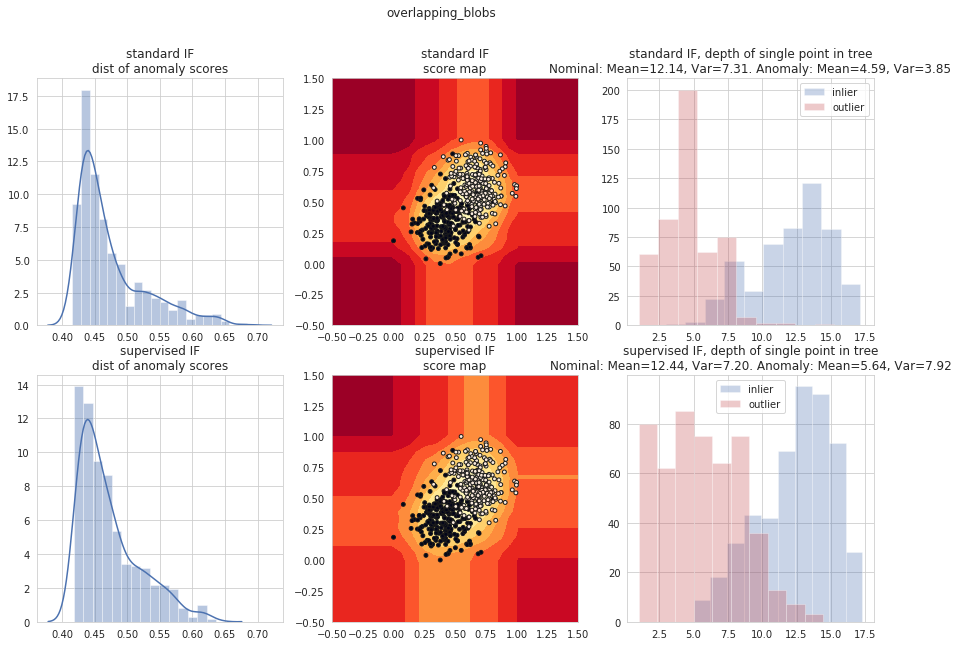

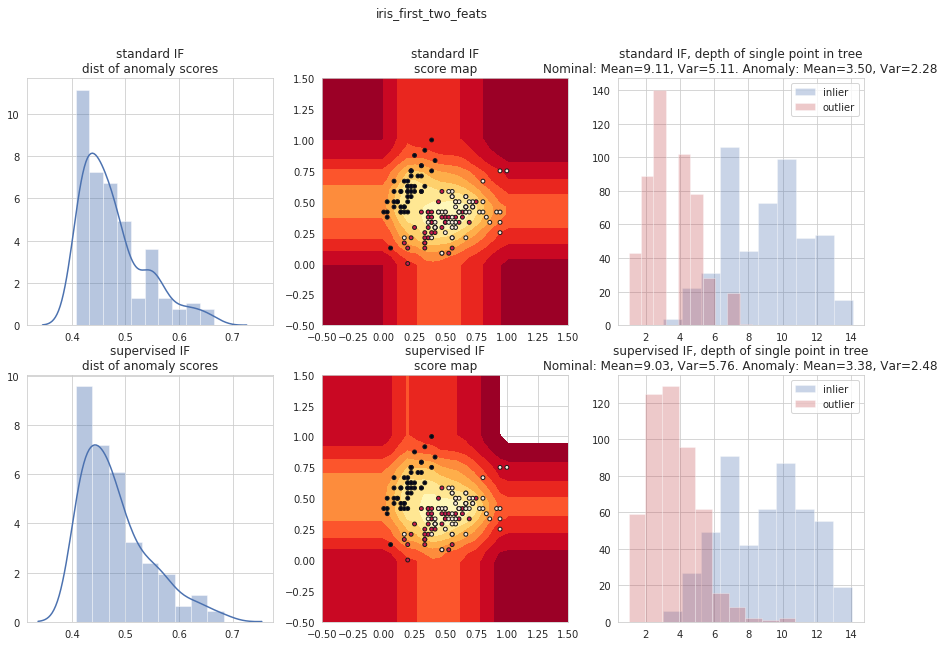

In [6]:
for name, ds in zip(names, datasets):
    plot_sif(ds, name, n_trees=500)